# Predicting Hospital Readmission for Diabetes Patients

## Objective
Demonstrate an end-to-end machine learning pipeline to predict whether a patient will be readmitted to a hospital after a diabetes diagnosis using data maintained by UCI detailing 10 years of clinical care at U.S. hospitals and integrated delivery networks.

## Table of Contents
* [Data Loading](#data_loading)
* [Data Cleaning & Preprocessing](#data_cleaning)
* [Exploratory Data Analysis (EDA)](#eda)
    * [Expore numeric data](#eda_numeric)
    * [Explore categorical data](#eda_categorical)
* [Feature Engineering](#feature_engineering)
* [Model Training & Evaluation](#model_training)
* [Model Finalization and Deployment Preparation](#model_finalization)

In [1]:
import io
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, RandomOverSampler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBClassifier

import requests

%matplotlib inline

## Data Loading <a class="anchor" id="data_loading"></a>

In [2]:
# URL of the dataset
url = "https://archive.ics.uci.edu/static/public/296/diabetes+130-us+hospitals+for+years+1999-2008.zip"

try:
    print("Downloading dataset...")
    response = requests.get(url, stream=True)
    response.raise_for_status() # raises error for bad HTTP responses

    print("Download successful! Extracting files...")
    zip_file = zipfile.ZipFile(io.BytesIO(response.content)) # open ZIP in memory

    # list the files
    files_list = zip_file.namelist()
    print("Files contained in ZIP:\n", ", ".join(files_list))

    # create a dictionary to store the files
    files = {}

    for file_name in files_list:
        with zip_file.open(file_name) as f:
            files[file_name] = pd.read_csv(f)

    # assign the DataFrames to variables
    df_diabetes = files.get("diabetic_data.csv")
    df_ids = files.get("IDS_mapping.csv")

except requests.exceptions.RequestException as e:
    print(f"Error downloading dataset: {e}")

except zipfile.BadZipFile:
    print("Error processing ZIP file")

except OSError as e:
    print(f"Error opening file: {e}")

except KeyError as e:
    print(f"Error retrieving file: {e}")

Download successful! Extracting files...
Files contained in ZIP:
 diabetic_data.csv, IDS_mapping.csv


## Data Cleaning & Preprocessing <a class="anchor" id="data_cleaning"></a>

In [3]:
# prepare the IDs DF for merging
df_ids.dropna(inplace=True)
df_filtered_ids = df_ids[df_ids["admission_type_id"].str.isdigit()].copy()
df_grouped_ids = df_filtered_ids.groupby("admission_type_id")["description"].apply(lambda x: " | ".join(x)).reset_index()

# prepare the diabetes DF for merging
df_diabetes["admission_type_id"] = df_diabetes["admission_type_id"].astype(str)

# merge the DFs
df = df_diabetes.merge(df_grouped_ids, how="left", on="admission_type_id")

In [4]:
# look at the data types
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id           object
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

In [5]:
# identify columns using a question mark as a null value
question_mark_cols = ", ".join(df.columns[(df == "?").any()])
print("Columns using \"?\" to signify null values:\n", question_mark_cols)

# replace "?" rows with NaN
df.where(df != "?", np.nan, inplace=True)

Columns using "?" to signify null values:
 race, weight, payer_code, medical_specialty, diag_1, diag_2, diag_3


In [6]:
def display_missing_value_columns(df):
    """Generates a DataFrame analyzing columns' null values.

    Args:
        df (pd.DataFrame): A dataset.

    Returns:
        pd.DataFrame: A DataFrame containing null statistics.
    """

    # get columns and their missing value counts
    missing_values = df.isna().sum()
    missing_values = missing_values[missing_values > 0].reset_index()

    # rename the columns and calculate the percentage of nulls
    missing_values.columns = ["column_name", "null_count"]
    missing_values["null_perc"] = missing_values["null_count"] / df.shape[0]

    # sort the values
    missing_values.sort_values(by="null_perc", ascending=False, inplace=True)

    return missing_values

In [7]:
# create a DF showing missing value statistics
display_missing_value_columns(df)

,column_name,null_count,null_perc
1,weight,98569,0.968585
7,max_glu_serum,96420,0.947468
8,A1Cresult,84748,0.832773
3,medical_specialty,49949,0.490822
2,payer_code,40256,0.395574
0,race,2273,0.022336
6,diag_3,1423,0.013983
5,diag_2,358,0.003518
4,diag_1,21,0.000206


In [8]:
# drop columns with 30% or more values missing
non_na_vals = df.shape[0] - (0.3 * df.shape[0])
df.dropna(thresh=non_na_vals, axis=1, inplace=True)

# drop the remaining null rows
df.dropna(inplace=True)

In [9]:
# check for duplicates
print(f"Total duplicate rows: {df.duplicated().sum()}")
df[df.duplicated()]

Total duplicate rows: 0


,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,description


In [10]:
# check for duplicate patient numbers (i.e., more than one encounter per patient)
grouped_patient_nbrs = df.groupby("patient_nbr")["encounter_id"].count().reset_index()
grouped_patient_nbrs.sort_values(by="encounter_id", ascending=False)

,patient_nbr,encounter_id
52030,88785891,39
15744,23199021,23
51618,88227540,23
3380,1660293,23
17718,23643405,22
...,...,...
25966,36531909,1
25967,36534087,1
25968,36535347,1
25970,36539487,1


In [11]:
# sort to keep only the patient number for the most recent encounter
df.sort_values(by=["patient_nbr", "encounter_id"], ascending=[True, False], inplace=True)
df.drop_duplicates(subset="patient_nbr", inplace=True)

In [12]:
# cast any identifer columns to an object type
cols_to_convert = df.filter(regex=r"_(?:id|nbr)$").columns
df[cols_to_convert] = df[cols_to_convert].astype(str)

In [13]:
# replace the age ranges with integer types that represent the average of that interval
df["age"] = df["age"].map({
    "[0-10)": 5, "[10-20)": 15, "[20-30)": 25, "[30-40)": 35, "[40-50)": 45,
    "[50-60)": 55, "[60-70)": 65, "[70-80)": 75, "[80-90)": 85, "[90-100)": 95})

In [14]:
# filter the data to keep only readmissions within a month
df = df[df["readmitted"].ne(">30")].copy()

In [15]:
def map_icd9_to_category(code):
    """Maps ICD-9 codes to disease categories.

    Args:
        code (str): A string value representing an ICD-9 code.
    Returns:
        str: A string value representing a disease classification.
    """

    try:
        code = str(code).strip()
        if code.startswith("250"):
            category =  "Diabetes-Related"
        elif code.startswith("E"):
            category =  "Supplementary Classification of External Causes of Injury and Poisoning"
        elif code.startswith("V"):
            category =  "Supplementary Classification of Factors influencing Health Status and Contact with Health Services"

        code = int(float(code))
        if 1 <= code <= 139:
            category =  "Infectious and Parasitic Diseases"
        elif 140 <= code <= 239:
            category =  "Neoplasms"
        elif 240 <= code <= 279:
            category =  "Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders"
        elif 280 <= code <= 289:
            category =  "Diseases of the Blood and Blood-forming Organs"
        elif 290 <= code <= 319:
            category =  "Mental Disorders"
        elif 320 <= code <= 389:
            category =  "Diseases of the Nervous System and Sense Organs"
        elif 390 <= code <= 459:
            category =  "Diseases of the Circulatory System"
        elif 460 <= code <= 519:
            category =  "Diseases of the Respiratory System"
        elif 520 <= code <= 579:
            category =  "Diseases of the Digestive System"
        elif 580 <= code <= 629:
            category =  "Diseases of the Genitourinary System"
        elif 630 <= code <= 679:
            category =  "Complications of Pregnancy, Childbirth, and the Puerperium"
        elif 680 <= code <= 709:
            category =  "Diseases of the Skin and Subcutaneous Tissue"
        elif 710 <= code <= 739:
            category =  "Diseases of the Musculoskeletal System and Connective Tissue"
        elif 740 <= code <= 759:
            category =  "Congenital Anomalies"
        elif 760 <= code <= 779:
            category =  "Certain Conditions originating in the Perinatal Period"
        elif 780 <= code <= 799:
            category =  "Symptoms, Signs and Ill-defined Conditions"
        elif 800 <= code <= 999:
            category =  "Injury and Poisoning"
        else:
            category =  "Other"

    except:
        category =  "Other"

    return category

In [16]:
# convert ICD-9 codes to disease categories
df[["disease_class_1", "disease_class_2", "disease_class_3"]] = df[["diag_1", "diag_2", "diag_3"]].apply(lambda col: col.map(map_icd9_to_category, na_action="ignore"))

## Exploratory Data Analysis <a class="anchor" id="eda"></a>

### Explore numeric data <a class="anchor" id="eda_numeric"></a>

In [17]:
# look at descriptive statistics for numeric columns
df.describe()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,55029.000000,55029.000000,55029.000000,55029.000000,55029.000000,55029.000000,55029.000000,55029.000000,55029.000000
mean,66.053808,4.320431,42.795599,1.422377,15.869560,0.287721,0.118483,0.418125,7.348961
std,15.760961,2.983919,19.844312,1.739200,8.407061,1.072697,0.562924,0.942256,1.893806
min,5.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000
25%,55.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,65.000000,4.000000,44.000000,1.000000,14.000000,0.000000,0.000000,0.000000,8.000000
75%,75.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,95.000000,14.000000,126.000000,6.000000,81.000000,40.000000,37.000000,16.000000,16.000000


In [18]:
def plot_numeric_distributions(df):
    """Generates a grid of boxplots and histograms for numeric columns.

    Args:
        df (pd.DataFrame): A dataset with numeric data.
    """

    # identify numeric columns
    numeric_cols = sorted(df.select_dtypes(include="number").columns)

    # get the number of numeric columns
    num_cols = len(numeric_cols)

    # create a figure and set of subplots
    fig, axs = plt.subplots(num_cols, 2, figsize=(10, 5 * num_cols))

    # create a side-by-side boxplot and histogram for each row
    for i, col in enumerate(numeric_cols):
        sns.boxplot(data=df, x=col, color="mediumvioletred", ax=axs[i, 0])
        axs[i, 0].set_title(f"Boxplot of {col}")

        sns.histplot(data=df, x=col, color="lightcoral", ax=axs[i, 1])
        axs[i, 1].set_title(f"Histogram of {col}")

    # prevent overlap and display figure
    plt.tight_layout()
    plt.show()

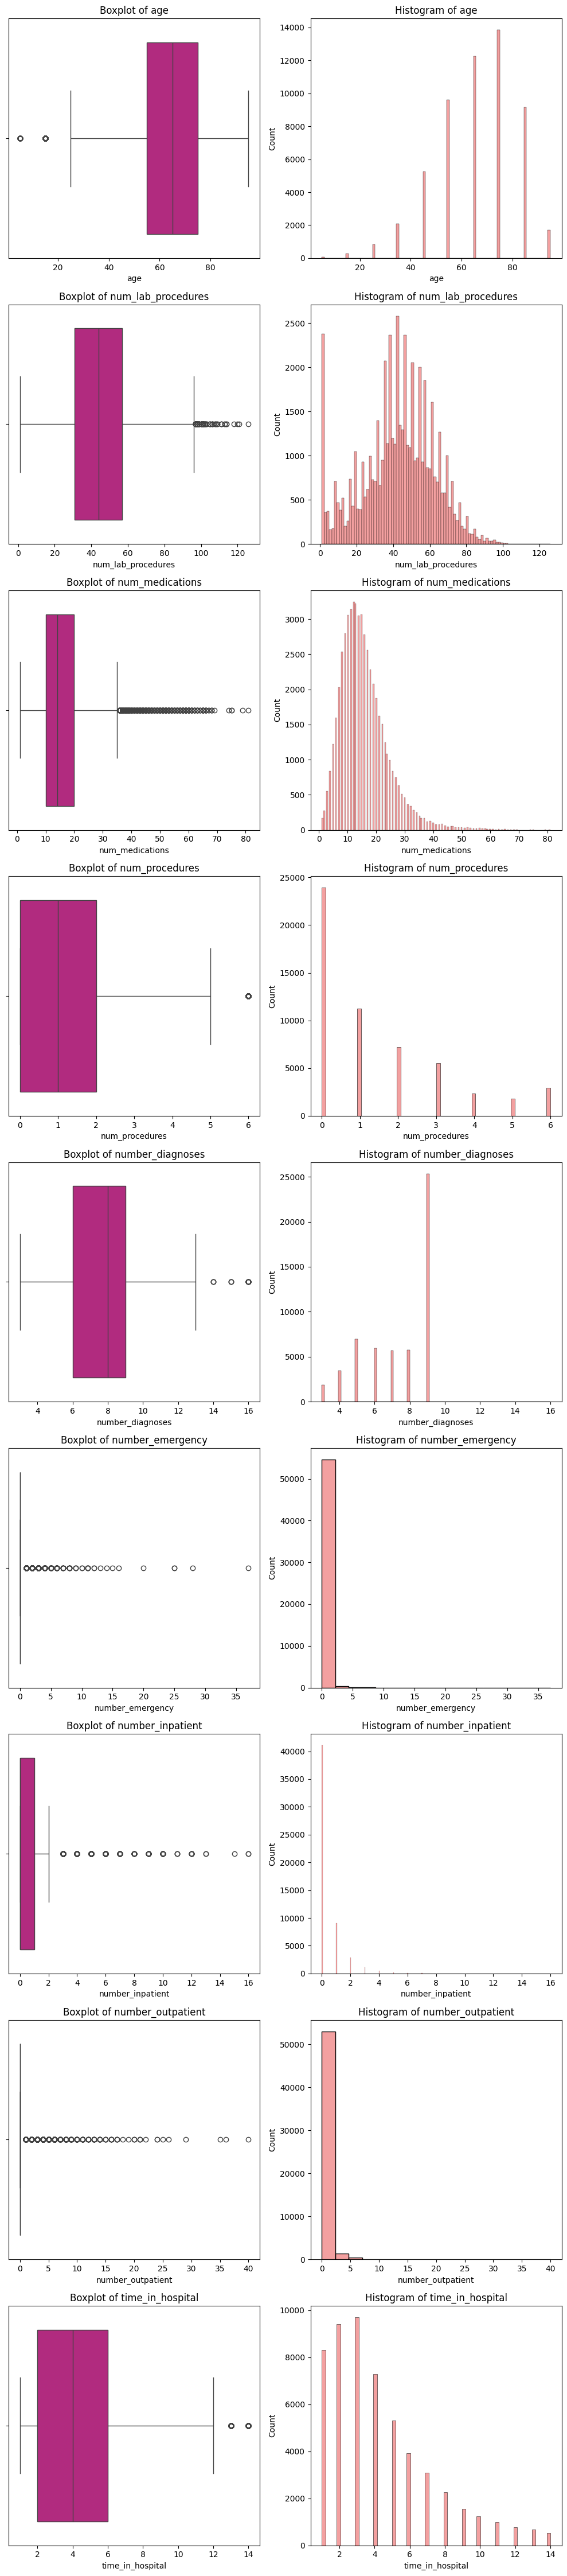

In [19]:
# analyze the distributions in the numeric data
plot_numeric_distributions(df)

In [20]:
def display_skewness_columns(df):
    """Generates a DataFrame analyzing columns' skewness.

    Args:
        df (pd.DataFrame): A dataset containing numeric data.

    Returns:
        pd.DataFrame: A DataFrame containing skewness values.
    """

    # check for skewness and rename columns
    skewness = df.select_dtypes(include="number").skew().reset_index()
    skewness.columns = ["column_name", "value"]

    # categorize the skewness
    conditions = [skewness["value"].abs().between(0.5, 1), skewness["value"].abs() > 1]
    choices = ["Moderate", "High"]
    skewness["skew_category"] = np.select(conditions, choices, default="Symmetric")

    # sort the values
    skewness.sort_values(by="value", ascending=False, inplace=True)

    return skewness

In [21]:
# create a DF showing skewness
display_skewness_columns(df)

,column_name,value,skew_category
6,number_emergency,17.183030,High
5,number_outpatient,9.050615,High
7,number_inpatient,3.910503,High
4,num_medications,1.418247,High
3,num_procedures,1.230317,High
1,time_in_hospital,1.162434,High
2,num_lab_procedures,-0.200487,Symmetric
0,age,-0.550626,Moderate
8,number_diagnoses,-0.672531,Moderate


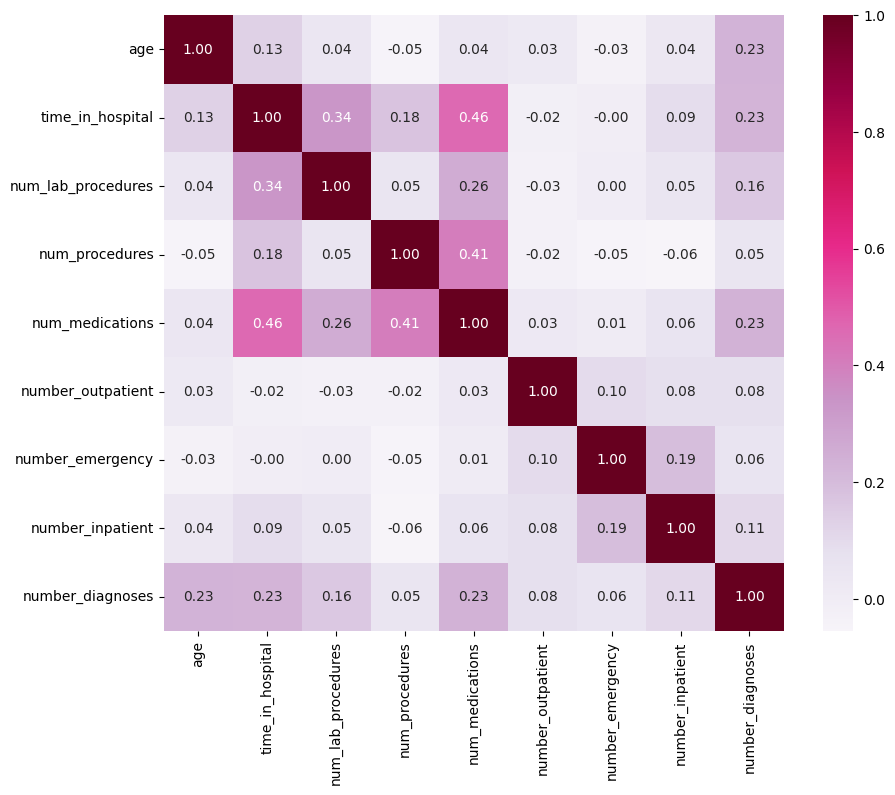

In [22]:
# analyze the strength of relationships among numeric columns
plt.figure(figsize=(10, 8))
corr_df = df.corr(numeric_only=True)
sns.heatmap(corr_df, cmap="PuRd", annot=True, fmt=".2f")
plt.show()

### Explore categorical data <a class="anchor" id="eda_categorical"></a>

In [23]:
# look at descriptive statistics for categorical columns
df.describe(include="object")

,encounter_id,patient_nbr,race,gender,admission_type_id,discharge_disposition_id,admission_source_id,diag_1,diag_2,diag_3,...,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,description,disease_class_1,disease_class_2,disease_class_3
count,55029,55029,55029,55029,55029,55029,55029,55029,55029,55029,...,55029,55029,55029,55029,55029,55029,55029,55029,55029,55029
unique,55029,55029,5,3,8,26,17,667,683,725,...,1,1,2,2,2,2,8,17,17,17
top,29758806,378,Caucasian,Female,1,1,7,414,250,250,...,No,No,No,No,Yes,NO,Emergency | Discharged to home | Physician Re...,Diseases of the Circulatory System,Diseases of the Circulatory System,Diseases of the Circulatory System
freq,1,1,41912,29186,28663,32542,29692,3855,3580,7020,...,55029,55029,55028,30710,41084,51865,28663,16342,16816,16173


In [24]:
def display_cardinality_columns(df):
    """Generates a DataFrame analyzing columns' cardinality.

    Args:
        df (pd.DataFrame): A dataset.

    Returns:
        pd.DataFrame: A DataFrame containing cardinality statistics.
    """

    # get columns and their number of unique values
    cardinal_values = df.select_dtypes(include=["category", "object"]).nunique().reset_index()

    # rename the columns and categorize the skewness
    cardinal_values.columns = ["column_name", "num_unique"]
    cardinal_values["cardinality"] = cardinal_values["num_unique"].apply(lambda x: "Low" if x < 15 else "Moderate" if 15 <= x < 50 else "High")

    # sort the values
    cardinal_values.sort_values(by="num_unique", ascending=False, inplace=True)

    return cardinal_values

In [25]:
# create a DF showing cardinality
display_cardinality_columns(df)

,column_name,num_unique,cardinality
0,encounter_id,55029,High
1,patient_nbr,55029,High
9,diag_3,725,High
8,diag_2,683,High
7,diag_1,667,High
5,discharge_disposition_id,26,Moderate
38,disease_class_2,17,Moderate
37,disease_class_1,17,Moderate
39,disease_class_3,17,Moderate
6,admission_source_id,17,Moderate


In [26]:
def plot_categorical_distributions(df, threshold=5):
    """Generates a grid of violin and count plots for categorical columns.

    Args:
        df (pd.DataFrame): A dataset with categorical data.
        threshold (int): The max number of unique values a column should have.
    """

    # identify categorical columns and remove ID columns
    unique_values = df.select_dtypes(include=["category", "object"]).nunique()
    categorical_cols = sorted(unique_values[unique_values.values <= threshold].index)

    # get the number of categorical columns
    num_cols = len(categorical_cols)

    # create a figure and set of subplots
    fig, axs = plt.subplots(num_cols, 2, figsize=(10, 5 * num_cols))

    # create a side-by-side violin plot and count plot for each row
    for i, col in enumerate(categorical_cols):

        sns.violinplot(data=df, x=col, color="mediumvioletred", ax=axs[i, 0])
        axs[i, 0].set_title(f"Boxplot of {col}")
        axs[i, 0].tick_params(axis="x", rotation=45)

        sns.countplot(data=df, x=col, color="lightcoral", ax=axs[i, 1])
        axs[i, 1].set_title(f"Histogram of {col}")
        axs[i, 1].tick_params(axis="x", rotation=45)

    # prevent overlap and display figure
    plt.tight_layout()
    plt.show()

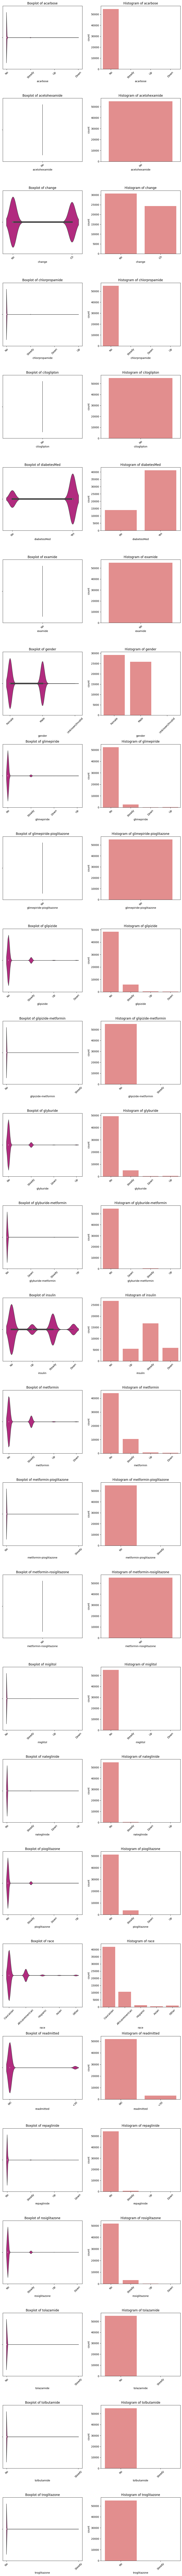

In [27]:
# analyze the distributions in the categorical data
plot_categorical_distributions(df)

In [28]:
def display_chi_square_columns(df, target_col):
    """Generates a DataFrame analyzing columns' null values.

    Args:
        df (pd.DataFrame): A dataset containing categorical columns.
        target_col (str): A variable that is being predicted on.

    Returns:
        pd.DataFrame: A DataFrame containing chi-square and p-value statistics.
    """

    # get categorical columns, except for identifier columns and the target
    categorical_cols = df.select_dtypes(include=["category", "object"]).columns
    categorical_df = df[categorical_cols].copy()
    categorical_df.drop(columns=["encounter_id", "patient_nbr", target_col], inplace=True)

    # initialize a dictionary to hold the chi-square test results
    result_dict = {"column_name": [], "chi_sq": [], "p_val": []}

    for col in categorical_df:

        # compute the contingency table
        contingency_table = pd.crosstab(df[col], df[target_col])

        # computes the chi-square statistic and p-value
        chi_sq, p_val, _, _ = chi2_contingency(contingency_table)

        # append the results
        result_dict["column_name"].append(col)
        result_dict["chi_sq"].append(round(chi_sq, 2))
        result_dict["p_val"].append(round(p_val, 2))

    # create a DataFrame from the results
    result_df = pd.DataFrame(result_dict).sort_values(by="p_val")
    result_df["is_significant"] = result_df["p_val"] < 0.05

    print(f"Columns with/without a significant association to the column, {target_col}:")

    return result_df

In [29]:
# create a DF showing chi-square and p-value statistics
display_chi_square_columns(df, "readmitted")

Columns with/without a significant association to the column, readmitted:


,column_name,chi_sq,p_val,is_significant
0,race,78.74,0.00,True
34,disease_class_1,104.31,0.00,True
33,description,403.31,0.00,True
32,diabetesMed,50.20,0.00,True
31,change,9.88,0.00,True
25,insulin,45.24,0.00,True
20,miglitol,17.25,0.00,True
35,disease_class_2,70.38,0.00,True
14,glipizide,25.32,0.00,True
36,disease_class_3,54.16,0.00,True


## Feature Engineering <a class="anchor" id="feature_engineering"></a>

In [30]:
cols_to_log = ["num_medications", "num_procedures", "number_emergency", "number_inpatient", "number_outpatient", "time_in_hospital"]

# log transform some of the numeric columns
for col in cols_to_log:
    df[f"{col}_log"] = np.log1p(df[col])

In [31]:
# look again at the skew to see if it improved
display_skewness_columns(df)

,column_name,value,skew_category
6,number_emergency,17.183030,High
5,number_outpatient,9.050615,High
11,number_emergency_log,4.106355,High
7,number_inpatient,3.910503,High
13,number_outpatient_log,3.110408,High
12,number_inpatient_log,1.805914,High
4,num_medications,1.418247,High
3,num_procedures,1.230317,High
1,time_in_hospital,1.162434,High
10,num_procedures_log,0.437913,Symmetric


In [32]:
# convert target values to numeric
df["readmitted"] = df["readmitted"].map({"NO": 0, "<30": 1})

In [33]:
# choose a subset of the data
numeric_features = ["age", "num_lab_procedures", "num_medications_log", "num_procedures_log", "number_diagnoses", "time_in_hospital_log"]
categorical_features = ["admission_type_id", "diabetesMed", "disease_class_1", "disease_class_2", "disease_class_3", "race"]
X = df[numeric_features + categorical_features]
y = df["readmitted"]

In [34]:
# split the data into train and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# add a validation set (25% of original 80% training data leaves 20% for validation -> 80/20/20)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

In [35]:
# initialize a tranformer to encode categorical features, scale numeric features
ct = ColumnTransformer([
    ("numeric", StandardScaler(), numeric_features),
    ("categorical", OneHotEncoder(drop="first", sparse_output=False), categorical_features)
])

# fit on the training data only
X_train_processed = ct.fit_transform(X_train)

# apply transformation on the validation, test sets
X_val_processed = ct.transform(X_val)
X_test_processed = ct.transform(X_test)

In [36]:
# retrieve the feature names
categorical_cols = ct.named_transformers_["categorical"].get_feature_names_out(categorical_features)
numeric_cols = ct.named_transformers_["numeric"].get_feature_names_out(numeric_features)
feature_cols = list(numeric_cols) + list(categorical_cols)

# convert back to a DataFrame
X_train_final = pd.DataFrame(X_train_processed, columns=feature_cols, index=X_train.index)
X_val_final = pd.DataFrame(X_val_processed, columns=feature_cols, index=X_val.index)
X_test_final = pd.DataFrame(X_test_processed, columns=feature_cols, index=X_test.index)

## Model Training and Evaluation <a class="anchor" id="model_training"></a>

In [37]:
def train_and_evaluate_models(models, X_train, X_test, y_train, y_test, plot_matrix=True):
    """Trains classification models, makes predictions, and evaluates performance.

    Trains and makes predictions on a dataset using classification models and computes key
    classification performance metrics (accuracy, precision, recall, F1).

    Args:
        models (dict): A dictionary of models to train. Format: {"Model Name": model_instance}.
        X_train (pd.DataFrame): A dataset containing feature data used for model training.
        X_test (pd.DataFrame): A dataset containing feature data used for model testing.
        y_train (pd.Series): A single column of data used for model training.
        y_test (pd.Series): A single column of data used for model testing.
        plot_matrix (bool): A flag to plot confusion matrices for each model.

    Returns:
        pd.DataFrame: A table containing metrics for each model.
    """

    # initialize a dictionary to store the results
    result_dict = {"model": list(models.keys()), "accuracy": [], "precision": [], "recall": [], "f1": []}

    for model_name, model in models.items():

        # train the model and generate predictions
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # compute evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # store the results
        result_dict["accuracy"].append(accuracy)
        result_dict["precision"].append(precision)
        result_dict["recall"].append(recall)
        result_dict["f1"].append(f1)

        if plot_matrix:

            # get the distinct labels
            display_labels = np.unique(np.concatenate([y_test, y_pred]))

            # generate and display confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

            # plot the confusion matrix
            disp.plot(cmap="PuRd", values_format="d")
            plt.title(f"Confusion Matrix - {model_name}")
            plt.show()

    # convert the dictionary to a DataFrame
    result_df = pd.DataFrame(result_dict)

    return result_df

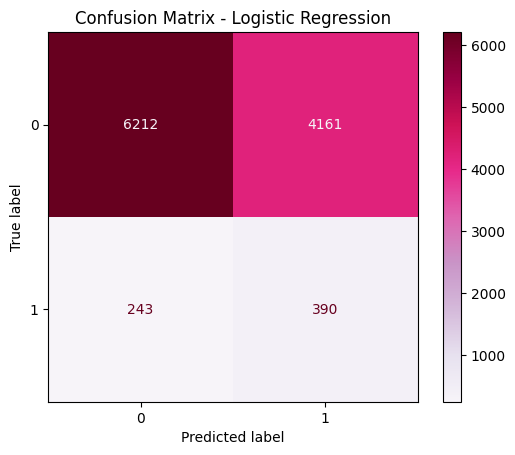

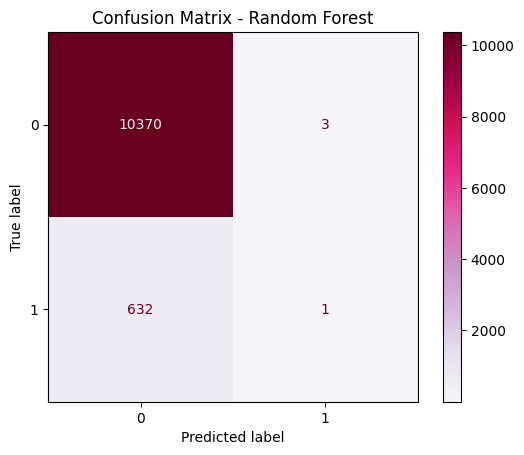

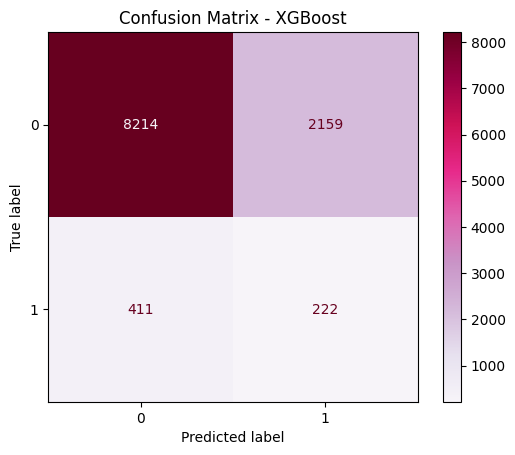

,model,accuracy,precision,recall,f1
0,Logistic Regression,0.599855,0.085695,0.616114,0.150463
1,Random Forest,0.942304,0.250000,0.001580,0.003140
2,XGBoost,0.766491,0.093238,0.350711,0.147313


In [38]:
# initialize models
lr = LogisticRegression(class_weight="balanced", max_iter=500, random_state=42)
rf = RandomForestClassifier(class_weight="balanced", random_state=42)
xgb = XGBClassifier(scale_pos_weight=16, random_state=42) # 51865 (NO) / 3164 (<30) = 16.4

# store in a dictionary
models = {"Logistic Regression": lr, "Random Forest": rf, "XGBoost": xgb}

# train the classifiers and analyze performance
train_and_evaluate_models(models, X_train_final, X_val_final, y_train, y_val)

In [39]:
def optimize_model_hyperparameters(X_train, y_train):
    """Finds optimal hyperparameters for three classification models.

    Trains and makes predictions on a dataset using

    - Logistic Regression,
    - Random Forest,
    - and XGBoost

    and computes key classification performance metrics (accuracy, precision, recall, F1).

    Args:
        X_train (pd.DataFrame): A dataset containing feature data used for model training.
        y_train (pd.Series): A single column of data used for model training.

    Returns:
        dict: A dictionary containing refined models.
    """

    # initialize base models
    lr = LogisticRegression(random_state=42)
    rf = RandomForestClassifier(random_state=42)
    xgb = XGBClassifier(random_state=42)

    # define parameter grids for each model
    lr_param_grid = {
        "penalty":  ["l1", "l2"],
        "C": [0.001, 0.01, 0.1, 1.0, 10.0],
        "class_weight": ["balanced"],
        "solver": ["liblinear", "saga"],
        "max_iter": [2000]
    }

    rf_param_grid = {
        "n_estimators": [100, 300],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "class_weight": ["balanced", "balanced_subsample"]
    }

    xgb_param_grid = {
        "n_estimators": [100, 300],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.1],
        "subsample": [0.75, 1.0],
        "colsample_bytree": [0.75, 1.0],
        "scale_pos_weight": [3, 10, 16]
    }

    # create grid search objects
    print("Logistic Regression: Finding optimal parameters...")
    lr_clf = GridSearchCV(lr, lr_param_grid, scoring="f1", n_jobs=-1)

    print("Random Forest: Finding optimal parameters...")
    rf_clf = GridSearchCV(rf, rf_param_grid, scoring="f1", n_jobs=-1)

    print("XGBoost: Finding optimal parameters...")
    xgb_clf = GridSearchCV(xgb, xgb_param_grid, scoring="f1", n_jobs=-1)

    # fit each model
    print("Logistic Regression: Fitting...")
    lr_clf.fit(X_train, y_train)

    print("Random Forest: Fitting...")
    rf_clf.fit(X_train, y_train)

    print("XGBoost: Fitting...")
    xgb_clf.fit(X_train, y_train)

    # print the best parameters and scores
    print("\n--Best Parameters and Scores--")
    print(f"Logistic Regression: {lr_clf.best_params_}")
    print(f"Best (avg) cross-validated CV F1 score: {lr_clf.best_score_}")

    print(f"\nRandom Forest: {rf_clf.best_params_}")
    print(f"Best (avg) CV F1 score: {lr_clf.best_score_}")

    print(f"\nXGBoost: {xgb_clf.best_params_}")
    print(f"Best (avg) cross-validated F1 score: {lr_clf.best_score_}")

    # package the hyperparameter-tuned models
    optimized_models = {
        "Logistic Regression": lr_clf.best_estimator_,
        "Random Forest": rf_clf.best_estimator_,
        "XGBoost": xgb_clf.best_estimator_
    }

    return optimized_models

In [40]:
# perform hyperparameter tuning on the classification models
optimized_models = optimize_model_hyperparameters(X_train_final, y_train)

Logistic Regression: Finding optimal parameters...
Random Forest: Finding optimal parameters...
XGBoost: Finding optimal parameters...
Logistic Regression: Fitting...
Random Forest: Fitting...
XGBoost: Fitting...

--Best Parameters and Scores--
Logistic Regression: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}
Best (avg) cross-validated CV F1 score: 0.15266297661514022

Random Forest: {'class_weight': 'balanced_subsample', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best (avg) CV F1 score: 0.15266297661514022

XGBoost: {'colsample_bytree': 0.75, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'scale_pos_weight': 10, 'subsample': 0.75}
Best (avg) cross-validated F1 score: 0.15266297661514022


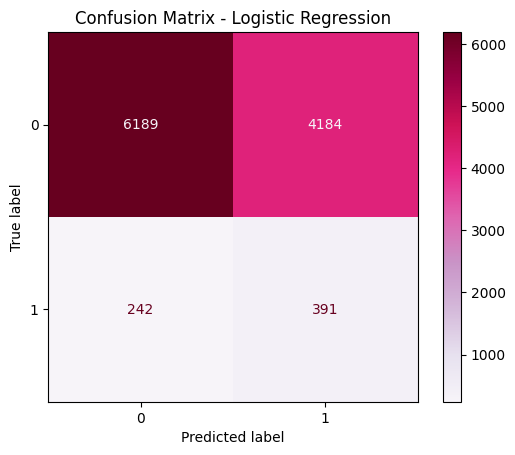

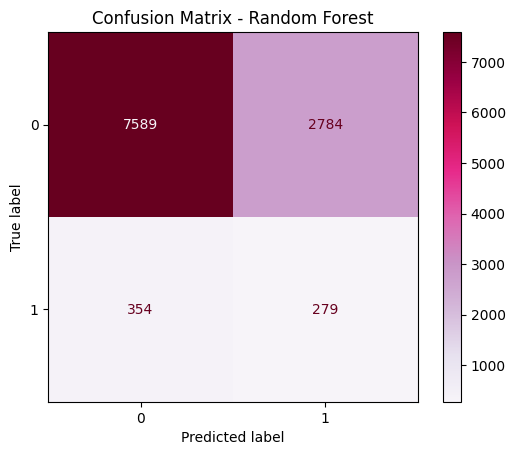

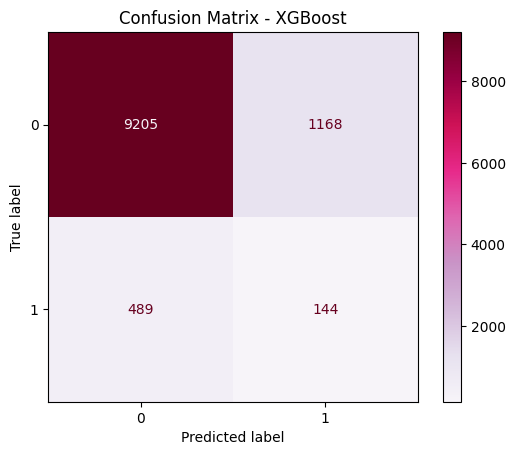

,model,accuracy,precision,recall,f1
0,Logistic Regression,0.597856,0.085464,0.617694,0.150154
1,Random Forest,0.714883,0.091087,0.440758,0.150974
2,XGBoost,0.849446,0.109756,0.227488,0.148072


In [41]:
# train the optimized classifiers and analyze performance
train_and_evaluate_models(optimized_models, X_train_final, X_val_final, y_train, y_val)

In [42]:
def compare_metrics_after_resampling(models, X_train, X_test, y_train, y_test):
    """Compares model performance across different resampling techniques.

    Acts as a wrapper function for train_and_evaluate_models. Applies resampling using

    - ADASYN
    - BorderlineSMOTE
    - SMOTE
    - SMOTETomek
    - RandomOverSampler

    and compares against the baseline metrics.

    Args:
        models (dict): A dictionary of models to train. Format: {"Model Name": model_instance}.
        X_train (pd.DataFrame): A dataset containing feature data used for model training.
        X_test (pd.DataFrame): A dataset containing feature data used for model testing.
        y_train (pd.Series): A single column of data used for model training.
        y_test (pd.Series): A single column of data used for model testing.

    Returns:
        pd.DataFrame: A table containing metrics for each model and sampling technique.
    """

    techniques = {
        "baseline": lambda x, y: (x, y),
        "adasyn": lambda x, y: ADASYN(random_state=42).fit_resample(X_train, y_train),
        "borderline": lambda x, y: BorderlineSMOTE(random_state=42).fit_resample(X_train, y_train),
        "smote": lambda x, y: SMOTE(random_state=42).fit_resample(X_train, y_train),
        "smote_tomek": lambda x, y: SMOTETomek(random_state=42).fit_resample(X_train, y_train),
        "rand_overs": lambda x, y: RandomOverSampler(random_state=42).fit_resample(X_train, y_train)
    }

    dfs = []

    for name, technique in techniques.items():

        # apply resampling on the training set
        X_train_resampled, y_train_resampled = technique(X_train, y_train)

        # train and evaluate the models' performance
        res = train_and_evaluate_models(models, X_train_resampled, X_test, y_train_resampled, y_test, False)

        # add the technique as a new column for each DF
        res.insert(0, "technique", name)

        # append the DataFrame to the list
        dfs.append(res)

    # append all results to a new DataFrame
    result_df = pd.concat(dfs, ignore_index=True)

    # convert to a pivot table
    result_df = pd.pivot_table(
        result_df,
        values=["accuracy", "precision", "recall", "f1"],
        index=["technique"],
        columns=["model"]).round(4)

    return result_df

In [43]:
# compare metrics from resampling against the baseline
result_df = compare_metrics_after_resampling(optimized_models, X_train_final, X_val_final, y_train, y_val)

# display the results
result_df

accuracy                                        f1  \
model       Logistic Regression Random Forest XGBoost Logistic Regression   
technique                                                                   
adasyn                   0.5989        0.8126  0.5413              0.1498   
baseline                 0.5979        0.7149  0.8494              0.1502   
borderline               0.6334        0.7931  0.5676              0.1496   
rand_overs               0.5989        0.6709  0.1690              0.1508   
smote                    0.6046        0.8092  0.5279              0.1483   
smote_tomek              0.6044        0.8057  0.5453              0.1483   

                                            precision                        \
model       Random Forest XGBoost Logistic Regression Random Forest XGBoost   
technique                                                                     
adasyn             0.1248  0.1426              0.0853        0.0853  0.0799   
baseline           0.1510  0.1481              0.0855        0.0911  0.1098   
borderline         0.1359  0.1479              0.0863        0.0894  0.0834   
rand_overs         0.1486  0.1168              0.0859        0.0873  0.0622   
smote              0.1265  0.1409              0.0847        0.0858  0.0787   
smote_tomek        0.1165  0.1452              0.0846        0.0789  0.0814   

                         recall                        
model       Logistic Regression Random Forest XGBoost  
technique                                              
adasyn                   0.6145        0.2322  0.6635  
baseline                 0.6177        0.4408  0.2275  
borderline               0.5608        0.2828  0.6524  
rand_overs               0.6193        0.4992  0.9558  
smote                    0.5987        0.2401  0.6730  
smote_tomek              0.5987        0.2227  0.6714

In [44]:
def train_and_evaluate_thresholds(models, X_train, X_test, y_train, y_test, plot_metrics=True):
    """Trains classification models and predicts class probabilities.

    Trains and makes class probability predictions at various thresholds on a dataset
    using classification models and computes key classification performance metrics
    (accuracy, precision, recall, F1).

    Args:
        models (dict): A dictionary of models to train. Format: {"Model Name": model_instance}.
        X_train (pd.DataFrame): A dataset containing feature data used for model training.
        X_test (pd.DataFrame): A dataset containing feature data used for model testing.
        y_train (pd.Series): A single column of data used for model training.
        y_test (pd.Series): A single column of data used for model testing.
        plot_metrics (bool): A flag to plot model performance metrics at different thresholds.

    Returns:
        pd.DataFrame: A table containing values that optimize metrics for each model.
    """

    # initialize a dictinary to store optimal metrics
    optimal_metrics = {"model": [], "threshold": [], "metric": [], "value": []}

    # define a range of thresholds to evaluate
    thresholds = np.linspace(0.05, 0.95, 19)

    # define a list of colors for each metric
    metric_colors = {
        "accuracy": "darkcyan",
        "precision": "deeppink",
        "recall": "darkviolet",
        "f1": "orangered"}

    for model_name, model in models.items():

        # initialize a dictionary to store metrics for plotting
        metrics = {"accuracy": [], "precision": [], "recall": [], "f1": []}

        # train the model and predict class probabilities
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1] # probability each sample is "<30"

        # calculate ROC/AUC data
        fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        for threshold in thresholds:

            # apply the threshold for predictions
            y_pred = (y_pred_proba >= threshold).astype(int)

            # compute evaluation metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)

            # store metrics for plotting
            metrics["accuracy"].append(accuracy)
            metrics["precision"].append(precision)
            metrics["recall"].append(recall)
            metrics["f1"].append(f1)

        for metric, values in metrics.items():

            # extract the threshold and value that maximize the metric
            max_idx = np.argmax(values)
            max_val = np.max(values)
            max_thr = thresholds[max_idx]

            # add the values to the results
            optimal_metrics["model"].append(model_name)
            optimal_metrics["metric"].append(metric)
            optimal_metrics["threshold"].append(max_thr)
            optimal_metrics["value"].append(max_val)

        if plot_metrics:

            # create a figure with two subplots side by side
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

            for metric in metrics.keys():

                ax1.plot(
                    thresholds,
                    metrics[metric],
                    color=metric_colors[metric],
                    marker="o",
                    linestyle="dashed",
                    linewidth=2,
                    markersize=6,
                    label=metric.title())

            ax1.set_title(f"Metrics vs Threshold - {model_name.title()}")
            ax1.set_xlabel("Threshold")
            ax1.set_ylabel("Score")
            ax1.legend()

            ax2.plot(fpr, tpr, color="darkgreen", linewidth=4, label=f"AUC = {roc_auc:.2f}")
            ax2.set_title(f"ROC Curve - {model_name.title()}")
            ax2.set_xlabel("False Positive Rate (1-Specificity)")
            ax2.set_ylabel("True Positive Rate (Sensitivity)")
            ax2.legend()

            plt.tight_layout()
            plt.show()

    # create a DataFrame with the results
    result_df = pd.DataFrame(optimal_metrics)

    return result_df

/Users/willnobles/Documents/datascience/metis-project3-classification/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


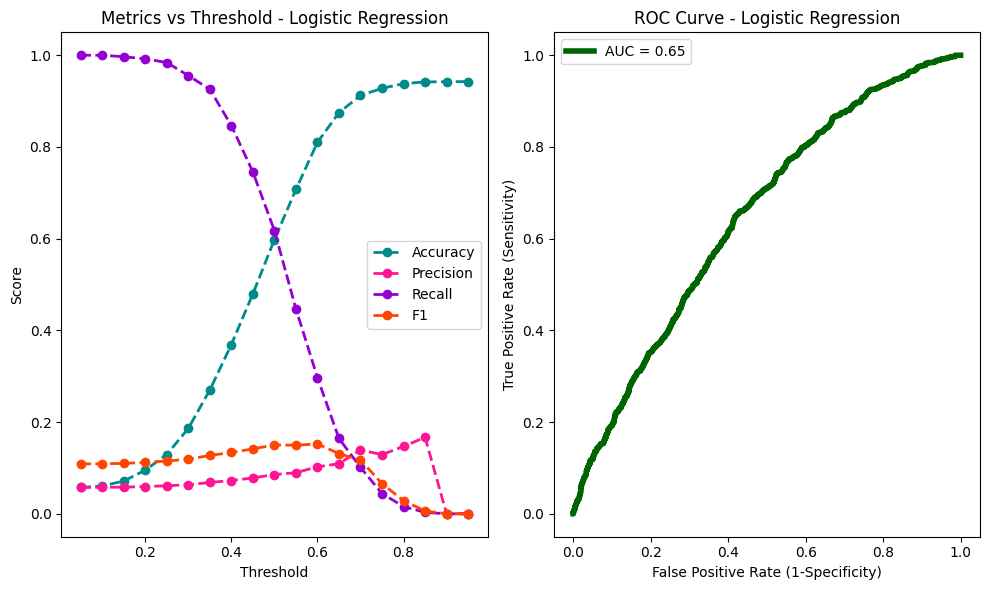

/Users/willnobles/Documents/datascience/metis-project3-classification/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/willnobles/Documents/datascience/metis-project3-classification/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/willnobles/Documents/datascience/metis-project3-classification/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `ze

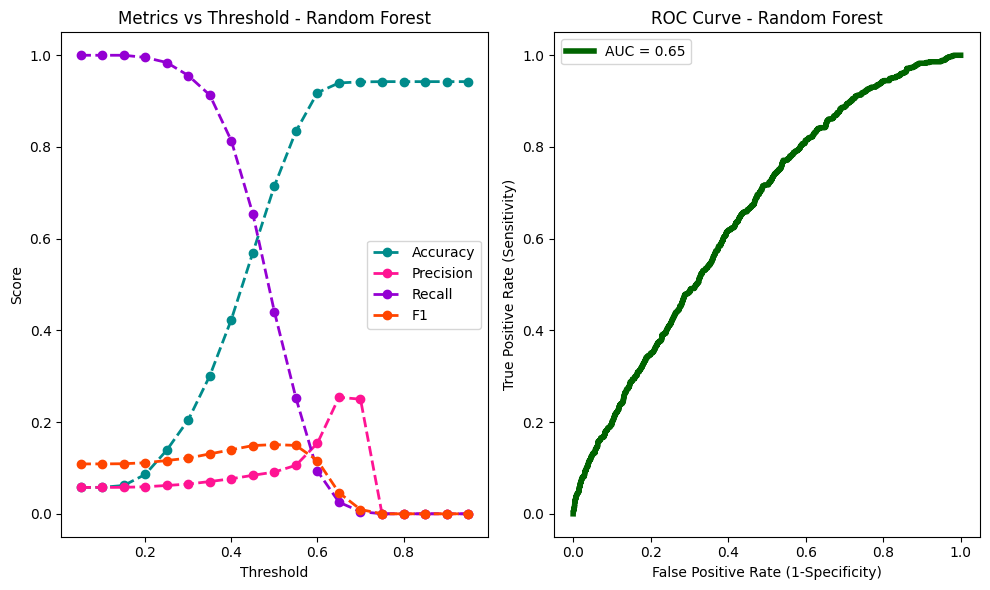

/Users/willnobles/Documents/datascience/metis-project3-classification/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/willnobles/Documents/datascience/metis-project3-classification/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


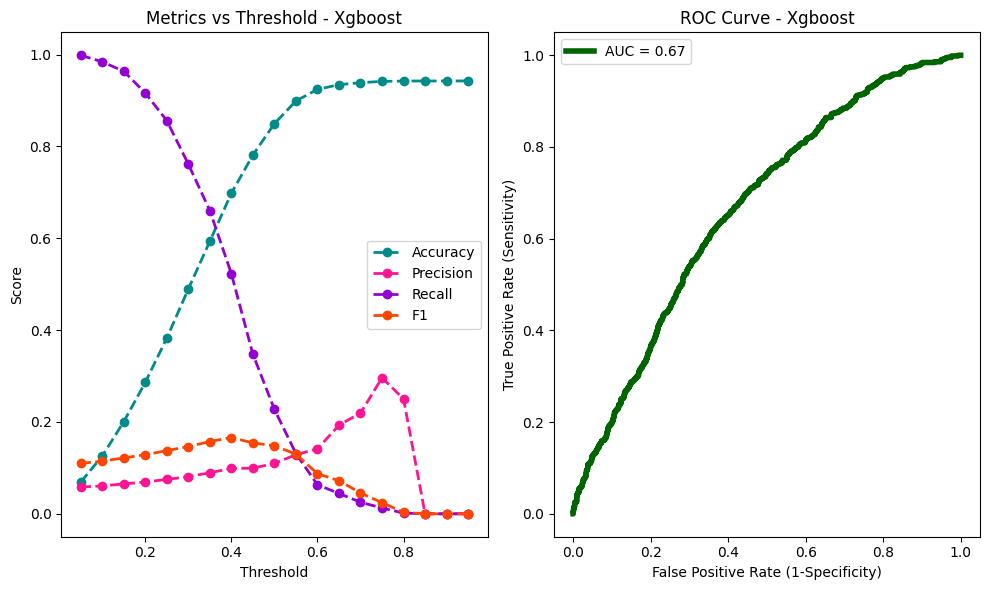

,model,threshold,metric,value
0,Logistic Regression,0.95,accuracy,0.942486
1,Logistic Regression,0.85,precision,0.166667
2,Logistic Regression,0.05,recall,1.000000
3,Logistic Regression,0.60,f1,0.152474
4,Random Forest,0.75,accuracy,0.942486
5,Random Forest,0.65,precision,0.253968
6,Random Forest,0.05,recall,1.000000
7,Random Forest,0.50,f1,0.150974
8,XGBoost,0.90,accuracy,0.942486
9,XGBoost,0.75,precision,0.296296


In [45]:
# evaluate metrics at different thresholds
result_df = train_and_evaluate_thresholds(optimized_models, X_train_final, X_val_final, y_train, y_val)

# display the results
result_df

## Model Finalization and Deployment Preparation <a class="anchor" id="model_finalization"></a>